# AML Diagnostic Subtype Classifier

```{contents}
```

## Load data

In [1]:
import pandas as pd
import numpy as np

input_path = '../../Data/Intermediate_Files/'
output_path = '../../Data/Processed_Data/'

# Load pacmap output data
df = pd.read_csv(output_path+'pacmap_output/pacmap_5d_output_acute_leukemia.csv', index_col=0)

# Save df to excel
df.to_excel('../data/pacmap_5d_output_acute_leukemia.xlsx')

## Preprocess data

### Select ELN 2022 annotated samples

In [2]:
# drop the samples with missing labels for the ELN AML 2022 Diagnosis
df_original = df.copy()
df = df[~df['ELN AML 2022 Diagnosis'].isna()]

# print the number of samples dropped and the amount remaining
print(df_original.shape[0]-df.shape[0], 'samples removed.'\
, df.shape[0], 'samples remaining.')

1783 samples removed. 1691 samples remaining.


### Select Dx subtypes with at least 10 samples

In [3]:
print(df['ELN AML 2022 Diagnosis'].value_counts(dropna=False))

# exclude the samples with mixed phenotypes and Down syndrome and t(9;22)(q34.1;q11.2)/BCR::ABL1
df2 = df[~df['ELN AML 2022 Diagnosis'].isin(['Mixed phenotype acute leukemia T/myeloid',
                                       'Myeloid leukaemia associated with Down syndrome',
                                       'AML with t(9;22)(q34.1;q11.2)/BCR::ABL1'])]

# print the number of samples dropped and the amount remaining
print(df.shape[0]-df2.shape[0], 'samples removed.'\
, df2.shape[0], 'samples remaining, which includes 110 test samples')
                                       

ELN AML 2022 Diagnosis
AML with t(9;11)(p22;q23.3)/KMT2A-rearrangement                           412
AML with t(8;21)(q22;q22.1)/RUNX1::RUNX1T1                                240
AML with inv(16)(p13.1q22) or t(16;16)(p13.1;q22)/CBFB::MYH11             221
AML with other rare recurring translocations                              200
AML with mutated NPM1                                                     190
MDS-related or secondary myeloid neoplasms                                153
Otherwise-Normal Control                                                  121
AML with in-frame bZIP mutated CEBPA                                       78
APL with t(15;17)(q24.1;q21.2)/PML::RARA                                   31
AML with t(6;9)(p23;q34.1)/DEK::NUP214                                     30
AML with inv(3)(q21.3q26.2) or t(3;3)(q21.3;q26.2)/MECOM-rearrangement     10
AML with t(9;22)(q34.1;q11.2)/BCR::ABL1                                     3
Myeloid leukaemia associated with Down sy

### Define X and y

In [4]:

# Define X and y
X = df2[['PaCMAP 1', 'PaCMAP 2', 'PaCMAP 3', 'PaCMAP 4', 'PaCMAP 5']].to_numpy() # shape (n_samples=1399, n_features=5)
y = df2['ELN AML 2022 Diagnosis'].to_numpy() # shape (n_samples=1399,) with 11 string classes

# Split the data into train/test sets based on the `Train Test` column
X_train = X[df2['Train Test']=='Discovery (train) Samples']
y_train = y[df2['Train Test']=='Discovery (train) Samples']
X_test = X[df2['Train Test']=='Validation (test) Samples']
y_test = y[df2['Train Test']=='Validation (test) Samples']

# print the number of samples in each set
print('X_train shape:', X_train.shape, 'X_test shape:', X_test.shape)

X_train shape: (1576, 5) X_test shape: (110, 5)


## LightGBM

Best parameters: {'learning_rate': 0.01, 'n_estimators': 200, 'num_leaves': 30}
Best cross-validation score: 0.953
Overall accuracy score with best estimator: 0.936


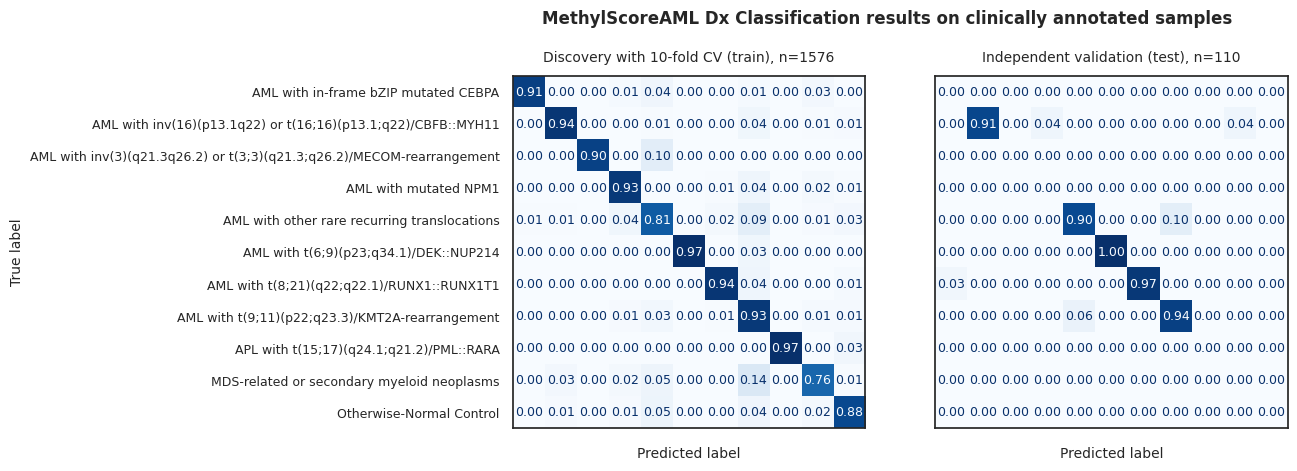

In [5]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score


# Import the custom function for plotting confusion matrix
import sys
sys.path.append('../')
from source.data_visualization_functions import plot_confusion_matrix_stacked

# Define the parameter grid
param_grid = {
    'num_leaves': [10, 20,30, 50, 100, 200], # number of leaves in full tree, which will roughly be the same as max number of features in one-hot encoding
    'learning_rate': [0.001, 0.01, 0.05, 0.1],  # learning rate
    'n_estimators': [50, 100, 200, 400],  # number of trees (or rounds)
}

# Initialize the LGBM Classifier
lgbm = LGBMClassifier(random_state=42, n_jobs=-1)

# Perform grid search with cross-validation
grid_search = GridSearchCV(lgbm, param_grid, cv=10, n_jobs=-1, scoring='roc_auc_ovr_weighted')
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

# Fit and predict using the best estimator
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)  # Predict using the best model

print(f'Overall accuracy score with best estimator: {accuracy_score(y_test, y_pred):.3f}')

plot_confusion_matrix_stacked(best_model, X_train, y_train, X_test, y_test, tick_fontsize=9, label_fontsize=9)


### Save model predictions

In [6]:
import numpy as np
#  Select necessary columns and set the index
df_selected = df_original.set_index('index')[['PaCMAP 1', 'PaCMAP 2', 'PaCMAP 3', 'PaCMAP 4', 'PaCMAP 5']]

# Predict using the selected columns
predictions = best_model.predict(df_selected)

# Predict probabilities using the selected columns
probabilities = best_model.predict_proba(df_selected)

# Convert predictions to a Series with the same index as df_selected
predictions_series = pd.Series(predictions, index=df_selected.index, name='MethylScoreAML_Dx_predictions')

# Convert probabilities to a DataFrame with the same index as df_selected and the same columns as the classes
probabilities_df = pd.DataFrame(probabilities, index=df_selected.index, columns=best_model.classes_).round(3)

# Add " - predict_proba" to the column names
probabilities_df.columns = probabilities_df.columns + ' - predict_proba'

# Create a new column named "Confident" and set it to True if the max probability is >= 0.8
confidence_threshold = 0.8
probabilities_df['Confidence >=' + str(confidence_threshold)] = probabilities_df.max(axis=1) >= confidence_threshold

# Join predictions with the original DataFrame (already indexed)
df_joined = df_original.set_index('index').join(predictions_series).join(probabilities_df)

# Select AML-only trials only
df_joined = df_joined[~df_joined['Clinical Trial'].isin(['NOPHO ALL92-2000', 'French GRAALL 2003–2005','TARGET ALL', np.nan])]

# For 'ELN AML 2022 Diagnosis', replace `na` with "AML, NOS (not otherwise specified)"
df_joined['ELN AML 2022 Diagnosis'] = df_joined['ELN AML 2022 Diagnosis'].fillna('AML, NOS (not otherwise specified)')

# Write the final DataFrame to a CSV file
df_joined.to_csv(output_path+'classifier_output/pacmap_5d_output_acute_leukemia_with_predictions.csv')
df_joined.to_excel('../data/pacmap_5d_output_acute_leukemia_with_predictions.xlsx')

## Gaussian Process

Best parameters: {'multi_class': 'one_vs_rest'}
Best cross-validation score: 0.951
Overall accuracy score with best estimator: 0.955


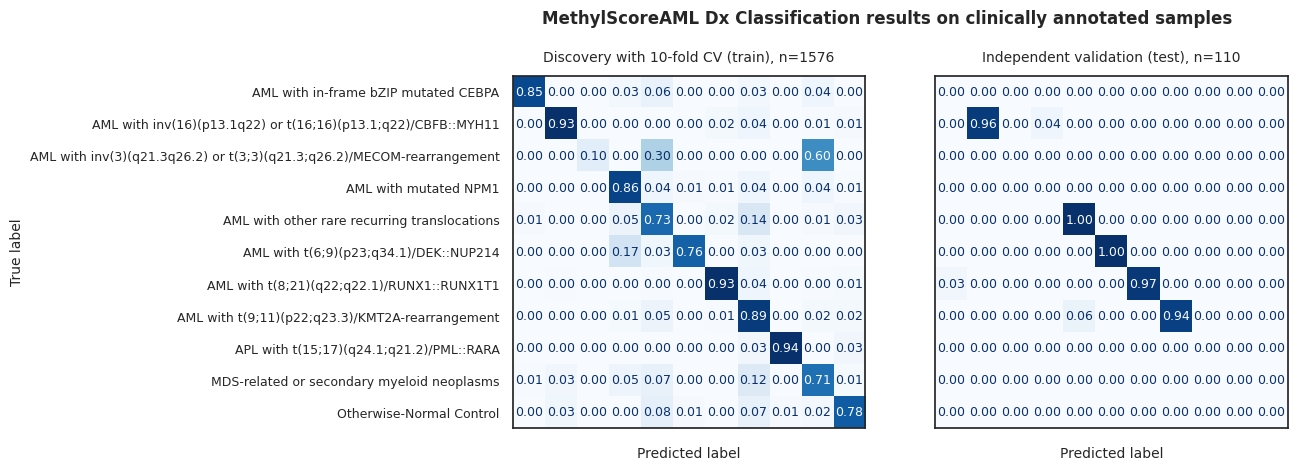

In [7]:
from sklearn.gaussian_process import GaussianProcessClassifier

# Define the parameter grid
param_grid = {
    'multi_class': ['one_vs_rest'],  # one_vs_rest is the only option for multi-class classification
}

# Initialize the Gaussian Process Classifier
gpc = GaussianProcessClassifier(random_state=42, n_jobs=-1)

# Perform grid search with cross-validation
grid_search = GridSearchCV(gpc, param_grid, cv=10, n_jobs=-1, scoring='roc_auc_ovr_weighted')
grid_search.fit(X_train, y_train)

# Fit and predict using the best estimator
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)  # Predict using the best model

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

# Fit and predict using the best estimator
best_model = grid_search.best_estimator_

print(f'Overall accuracy score with best estimator: {accuracy_score(y_test, y_pred):.3f}')

plot_confusion_matrix_stacked(best_model, X_train, y_train, X_test, y_test, tick_fontsize=9, label_fontsize=9)


## Random Forest

Best parameters: {'max_depth': 10, 'n_estimators': 200}
Best cross-validation score: 0.953
Overall accuracy score with best estimator: 0.945


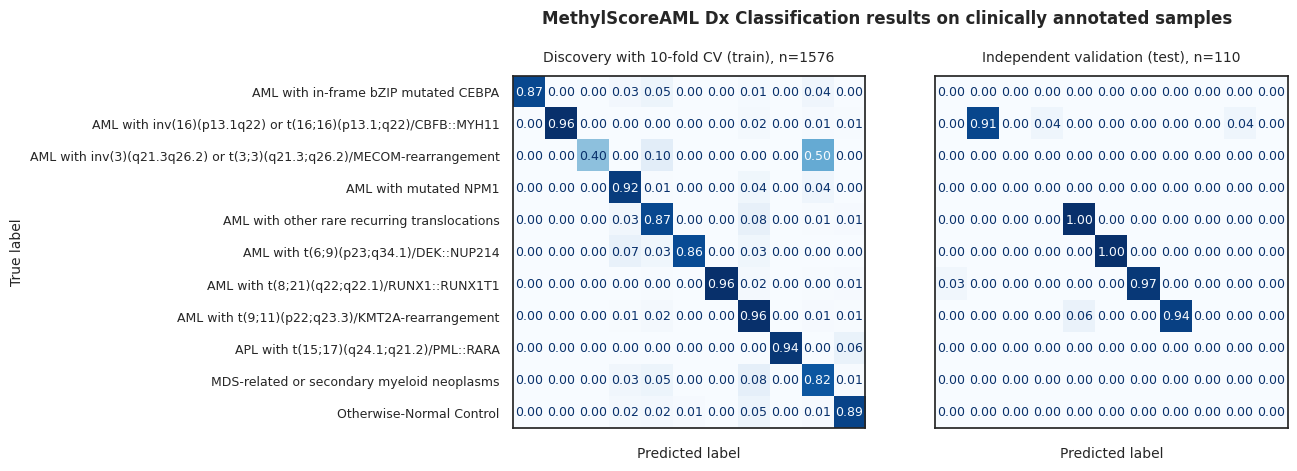

In [8]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # number of trees in the forest
    'max_depth': [None, 5, 10, 20, 50],  # maximum depth of the tree

}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=10, n_jobs=-1, scoring='roc_auc_ovr_weighted')
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

# Fit and predict using the best estimator
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)  # Predict using the best model

print(f'Overall accuracy score with best estimator: {accuracy_score(y_test, y_pred):.3f}')

plot_confusion_matrix_stacked(best_model, X_train, y_train, X_test, y_test, tick_fontsize=9, label_fontsize=9)


## Logistic Regression

Best parameters: {'C': 100, 'max_iter': 200, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.886
Overall accuracy score with best estimator: 0.882


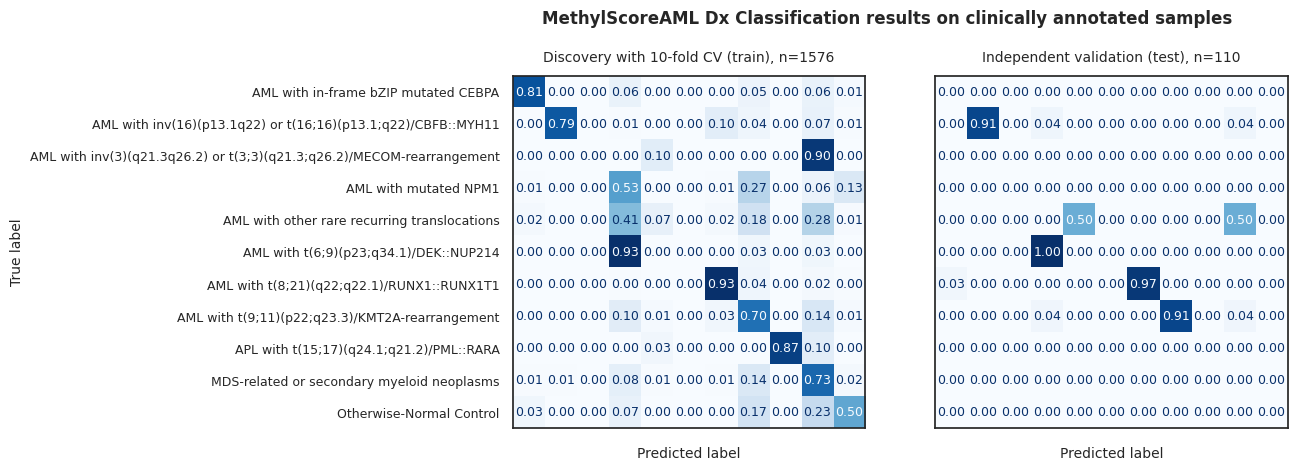

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # regularization strength, smaller values specify stronger regularization
    'penalty': ['l1', 'l2'],  # type of regularization applied
    'solver': ['liblinear'],   # algorithm to use in the optimization problem, 'liblinear' is good for small datasets
    'max_iter': [200, 500, 1000],  # maximum number of iterations taken for the solvers to converge
    'multi_class': ['ovr'],  # one_vs_rest is the only option for multi-class classification

}

# Initialize the Logistic Regression Classifier
lr = LogisticRegression(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(lr, param_grid, cv=10, n_jobs=-1, scoring='roc_auc_ovr_weighted')
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

# Fit and predict using the best estimator
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)  # Predict using the best model

print(f'Overall accuracy score with best estimator: {accuracy_score(y_test, y_pred):.3f}')

plot_confusion_matrix_stacked(best_model, X_train, y_train, X_test, y_test, tick_fontsize=9, label_fontsize=9)


## K-Nearest Neighbors

Best parameters: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Best cross-validation score: 0.793
Accuracy score with best estimator: 0.936


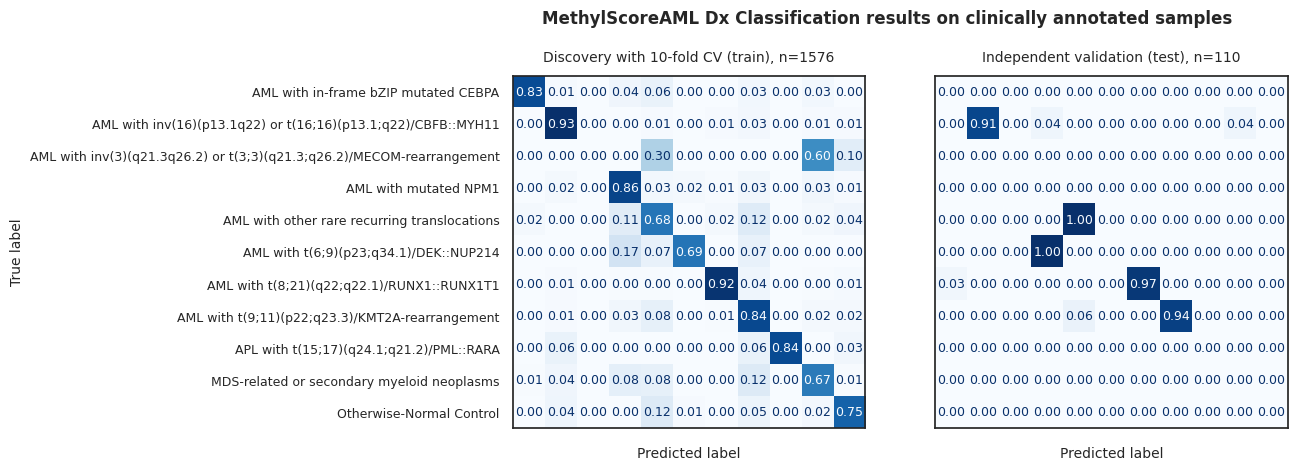

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Define the parameter grid
param_grid = {
    'n_neighbors': [7, 9, 12, 15, 18], 
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [1 ,2, 3, 5, 10],
    'p': [1, 2, 3]
}

# Initialize KNN classifier
knn = KNeighborsClassifier() 

# Perform grid search  
grid_search = GridSearchCV(knn, param_grid, cv=10, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

# Fit and predict using best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate model on test set
print(f'Accuracy score with best estimator: {accuracy_score(y_test, y_pred):.3f}')

plot_confusion_matrix_stacked(best_model, X_train, y_train, X_test, y_test, tick_fontsize=9, label_fontsize=9)

## Other tests

We have attempted SVM and XGBoost but they either gave us trouble during training or did not perform well.

Soon we will add a PyTorch deep learning benchmark but for now... `LightGBM` rules!

## Watermark

In [11]:
# Add watermark with all packages used
get_ipython().run_line_magic('load_ext', 'watermark')

In [12]:
get_ipython().run_line_magic('watermark', '-v -m -p numpy,pandas,sklearn,matplotlib,seaborn,lightgbm -a Francisco_Marchi@Lamba_Lab_UF')

Author: Francisco_Marchi@Lamba_Lab_UF

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.12.2

numpy     : 1.24.3
pandas    : 2.0.2
sklearn   : 1.2.2
matplotlib: 3.7.1
seaborn   : 0.12.2
lightgbm  : 3.3.5

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.133.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

